In [1]:
import string

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import emoji

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('../input/nlp-getting-started/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('\nTest Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB

Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


In [5]:
id_train=df_train['id']

id_test=df_test['id']

df_train.drop(columns='id',inplace=True)

df_test.drop(columns='id',inplace=True)

### **Duplicates processing**  

In [6]:
df_train.duplicated().sum()

52

In [7]:
duplicates = df_train[df_train.duplicated(keep=False)]
duplicates

,keyword,location,text,target
40,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
48,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
106,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
115,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
118,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29,0
...,...,...,...,...
6392,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6434,suicide%20bombing,NaN,'Suicide bombing at [location named]...' #premonitions http://t.co/iIkSsJGBDn,1
6449,suicide%20bombing,NaN,'Suicide bombing at [location named]...' #premonitions http://t.co/iIkSsJGBDn,1
6652,terrorist,MAD as Hell,RT AbbsWinston: #Zionist #Terrorist kidnapped 15 #Palestinians in overnight terror on Palestinian Villages Û_ http://t.co/J5mKcbKcov,1


In [8]:
df_train = df_train.drop_duplicates()
df_train.duplicated().sum()

0

### **Statistical characteristics of data**

In [9]:
df_train.isna().sum()

keyword       61
location    2500
text           0
target         0
dtype: int64

In [10]:
df_test.isna().sum()

keyword       26
location    1105
text           0
dtype: int64

In [11]:
print('Percent of missing keyword in train data: {:.2f}%'.format(100 * df_train['keyword'].isna().mean()))
print('Percent of missing location in train data: {:.2f}%'.format(100 * df_train['location'].isna().mean()))
print('\nPercent of missing keyword in test data: {:.2f}%'.format(100 * df_test['keyword'].isna().mean()))
print('Percent of missing location in test data: {:.2f}%'.format(100 * df_test['location'].isna().mean()))

Percent of missing keyword in train data: 0.81%
Percent of missing location in train data: 33.06%

Percent of missing keyword in test data: 0.80%
Percent of missing location in test data: 33.86%


**We can conlcude, that missing values are distributed uniformly between df_train and df_test**

In [12]:
print('Number of unique keyword values in train data: {}'.format(df_train['keyword'].nunique()))
print('Number of unique location values in train data: {}'.format(df_train['location'].nunique()))
print('\nNumber of unique keyword values in test data: {}'.format(df_test['keyword'].nunique()))
print('Number of unique location values in test data: {}'.format(df_test['location'].nunique()))

Number of unique keyword values in train data: 221
Number of unique location values in train data: 3341

Number of unique keyword values in test data: 221
Number of unique location values in test data: 1602


In [13]:
for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [14]:
print('Number of disasters: {}'.format(df_train['target'].sum()))
print('Number of non-disasters: {}'.format(df_train['target'].count() - df_train['target'].sum()))

Number of disasters: 3239
Number of non-disasters: 4322


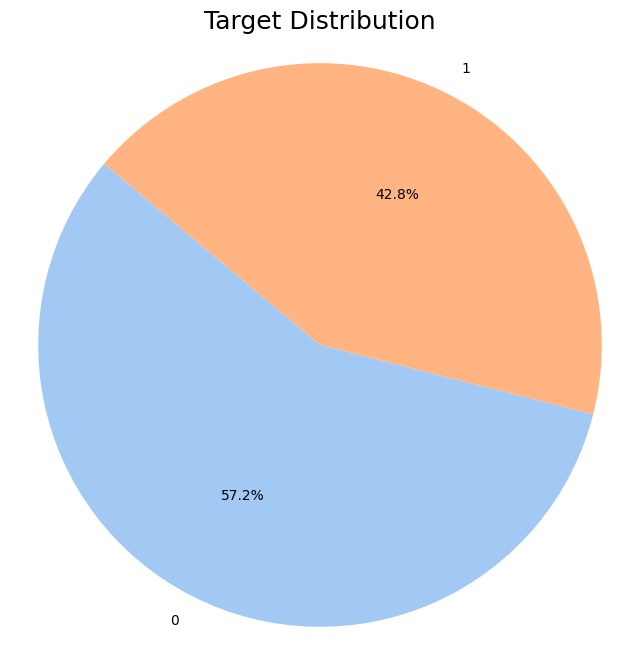

In [15]:
target_counts = df_train['target'].value_counts()

plt.figure(figsize=(8, 8), dpi=100)
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))

plt.title('Target Distribution', fontsize=18)
plt.axis('equal')

plt.show()

In [16]:
keyword_counts = df_train['keyword'].value_counts()
keyword_counts

keyword
no_keyword               61
fatalities               45
deluge                   42
armageddon               42
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 222, dtype: int64

In [17]:
location_counts = df_train['location'].value_counts()
location_counts

location
no_location                     2500
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
everydaynigerian@gmail.com         1
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
Lincoln                            1
Name: count, Length: 3342, dtype: int64

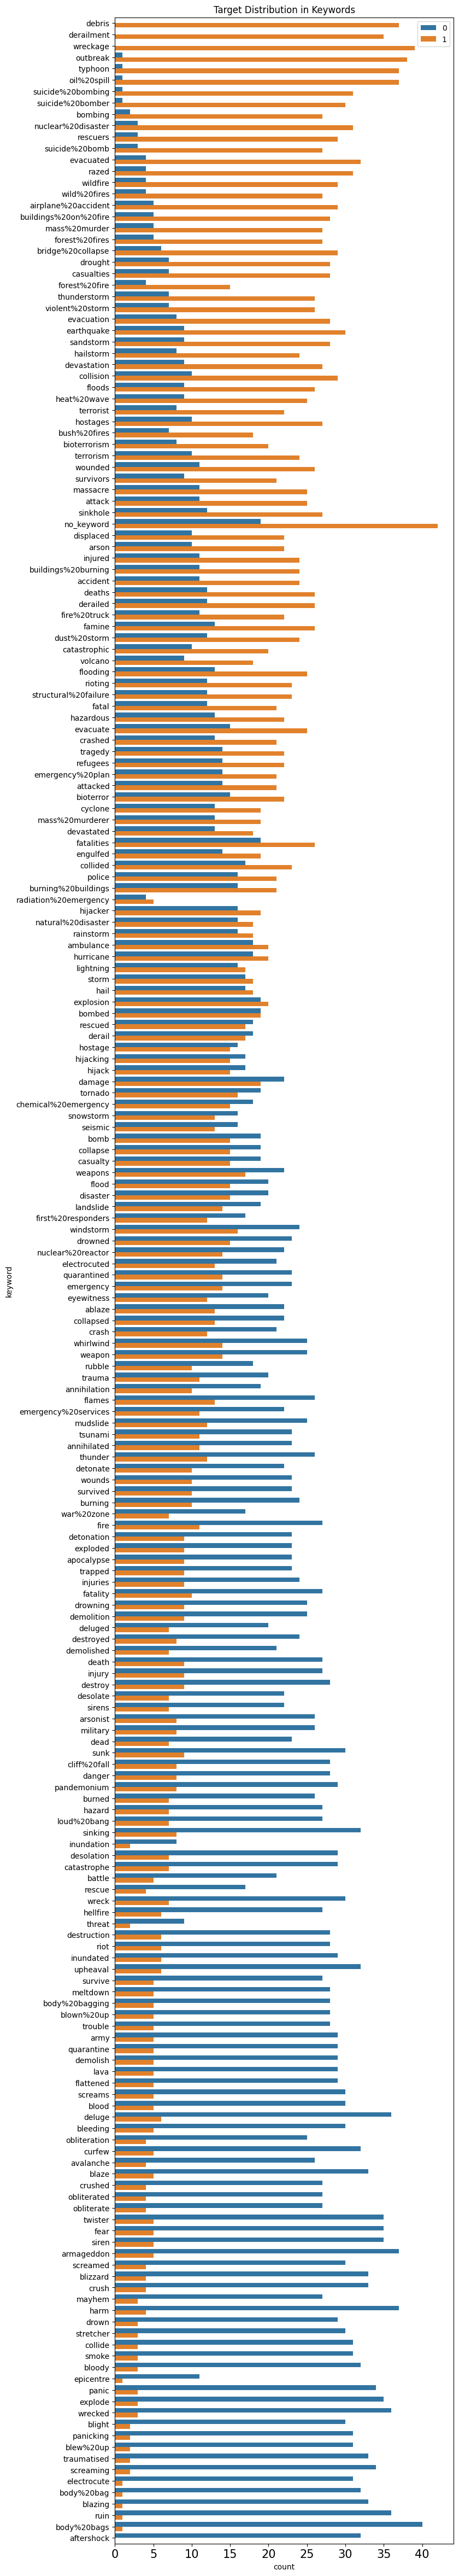

In [18]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 60), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=10)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

In [19]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

# Sentiment
sid = SentimentIntensityAnalyzer()

df_train['vader_neg'] = df_train['text'].apply(lambda x: sid.polarity_scores(str(x))['neg'])
df_test['vader_neg'] = df_test['text'].apply(lambda x: sid.polarity_scores(str(x))['neg'])

df_train['vader_neu'] = df_train['text'].apply(lambda x: sid.polarity_scores(str(x))['neu'])
df_test['vader_neu'] = df_test['text'].apply(lambda x: sid.polarity_scores(str(x))['neu'])

df_train['vader_pos'] = df_train['text'].apply(lambda x: sid.polarity_scores(str(x))['pos'])
df_test['vader_pos'] = df_test['text'].apply(lambda x: sid.polarity_scores(str(x))['pos'])

df_train['vader_compound'] = df_train['text'].apply(lambda x: sid.polarity_scores(str(x))['compound'])
df_test['vader_compound'] = df_test['text'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# Emoji count
df_train['emoji_count'] = df_train['text'].apply(lambda x: emoji.emoji_count(str(x)))
df_test['emoji_count'] = df_test['text'].apply(lambda x: emoji.emoji_count(str(x)))

# Capitalized words
df_train['caps_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper() and len(w)>1]))
df_test['caps_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper() and len(w)>1]))

# Exclamation marks
df_train['excl_count'] = df_train['text'].apply(lambda x: str(x).count('!'))
df_test['excl_count'] = df_test['text'].apply(lambda x: str(x).count('!'))

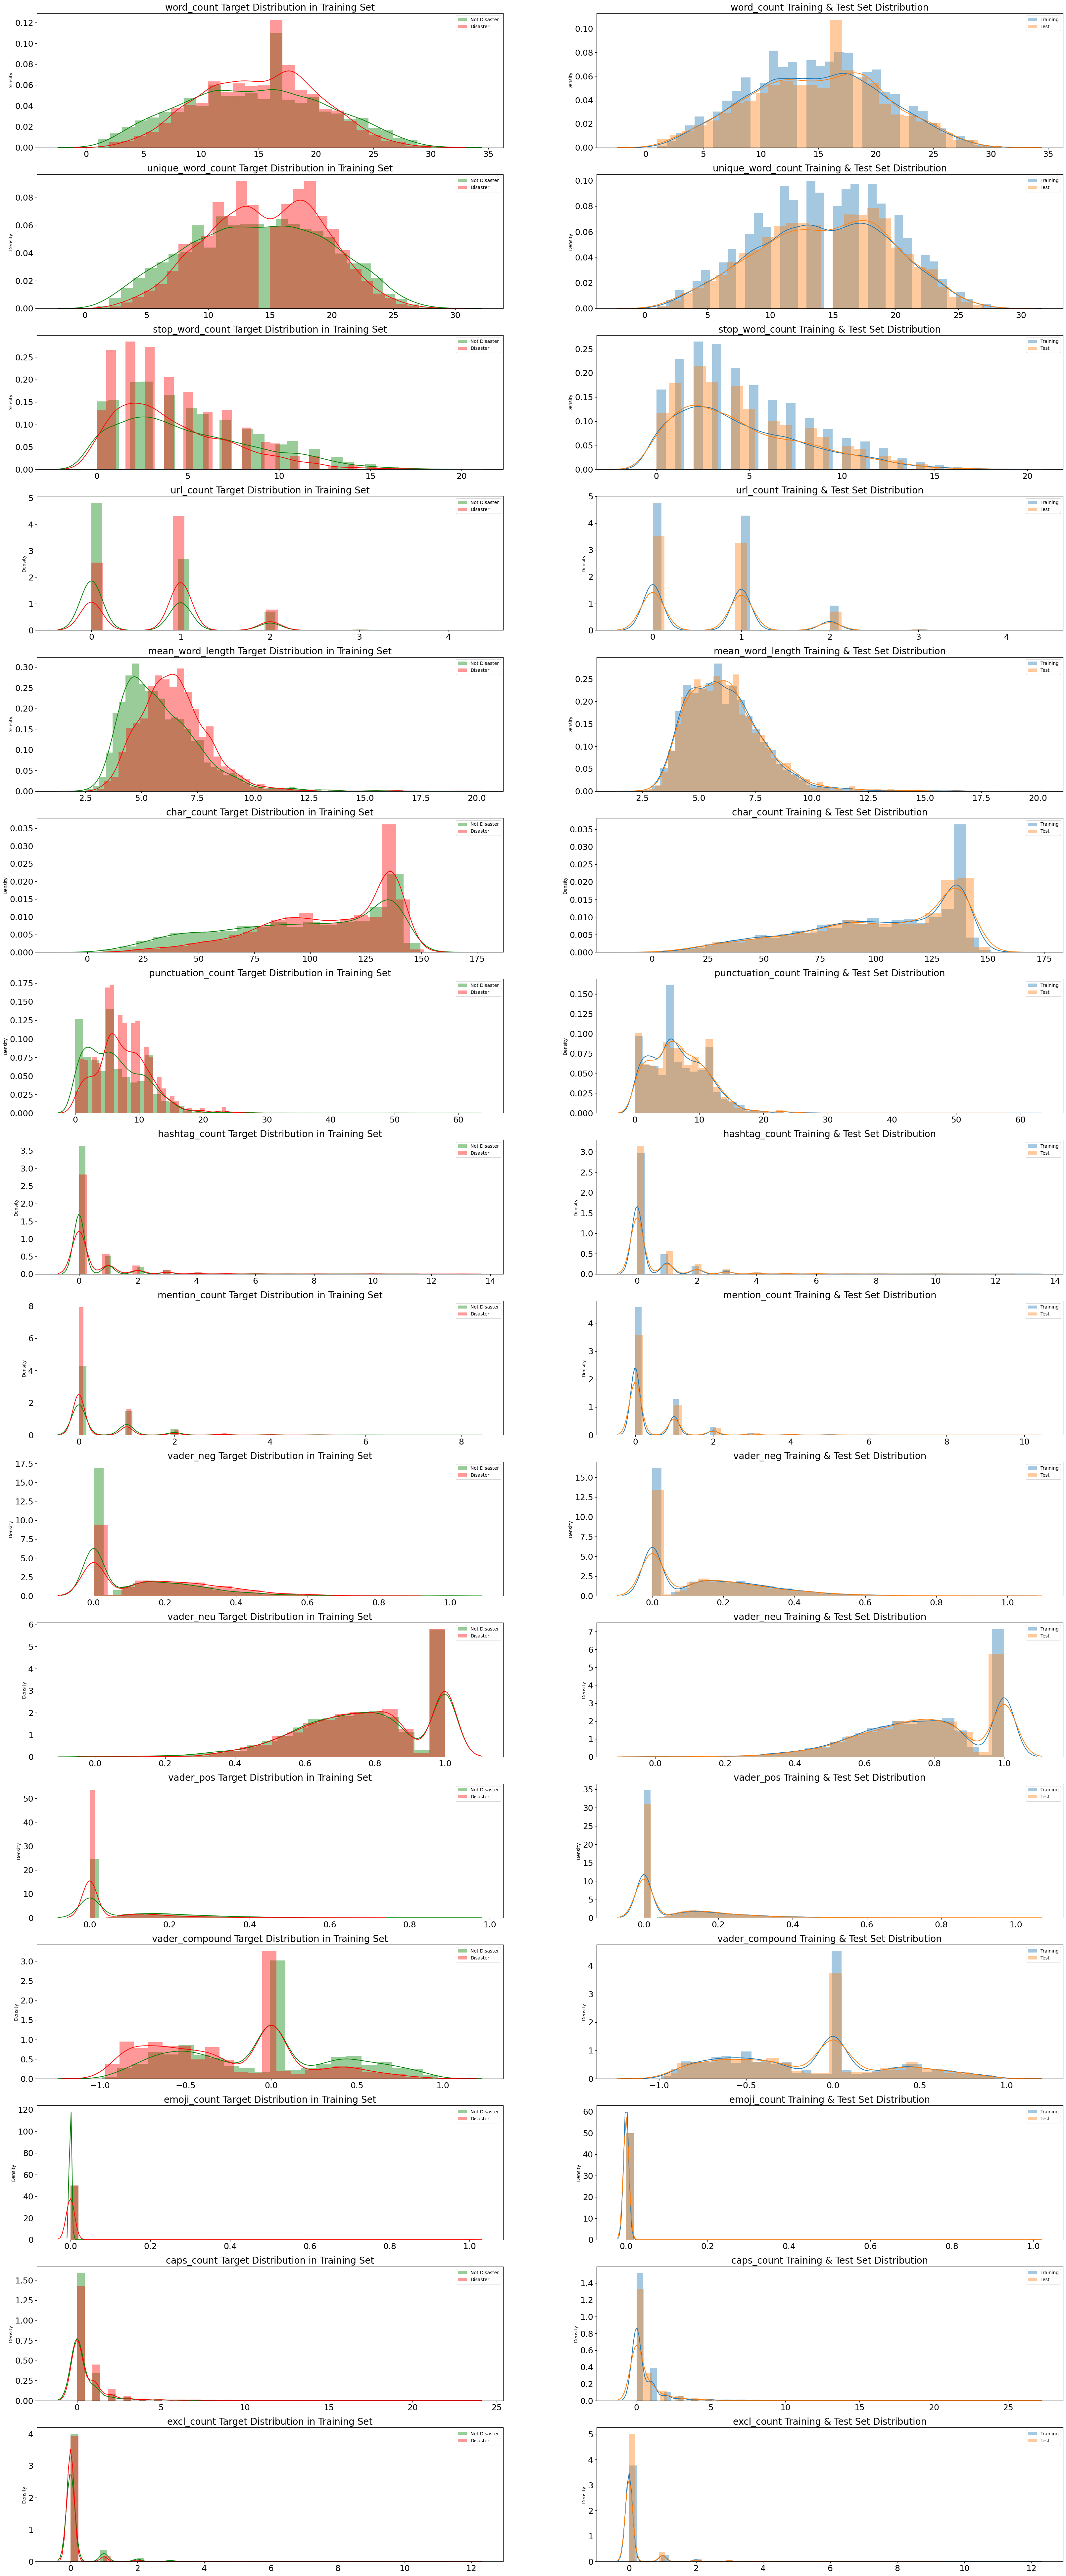

In [20]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 
                'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count',
                'mention_count', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
                'emoji_count', 'caps_count', 'excl_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(40, 100), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=18)
        axes[i][j].tick_params(axis='y', labelsize=18)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=20)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=20)

plt.show()

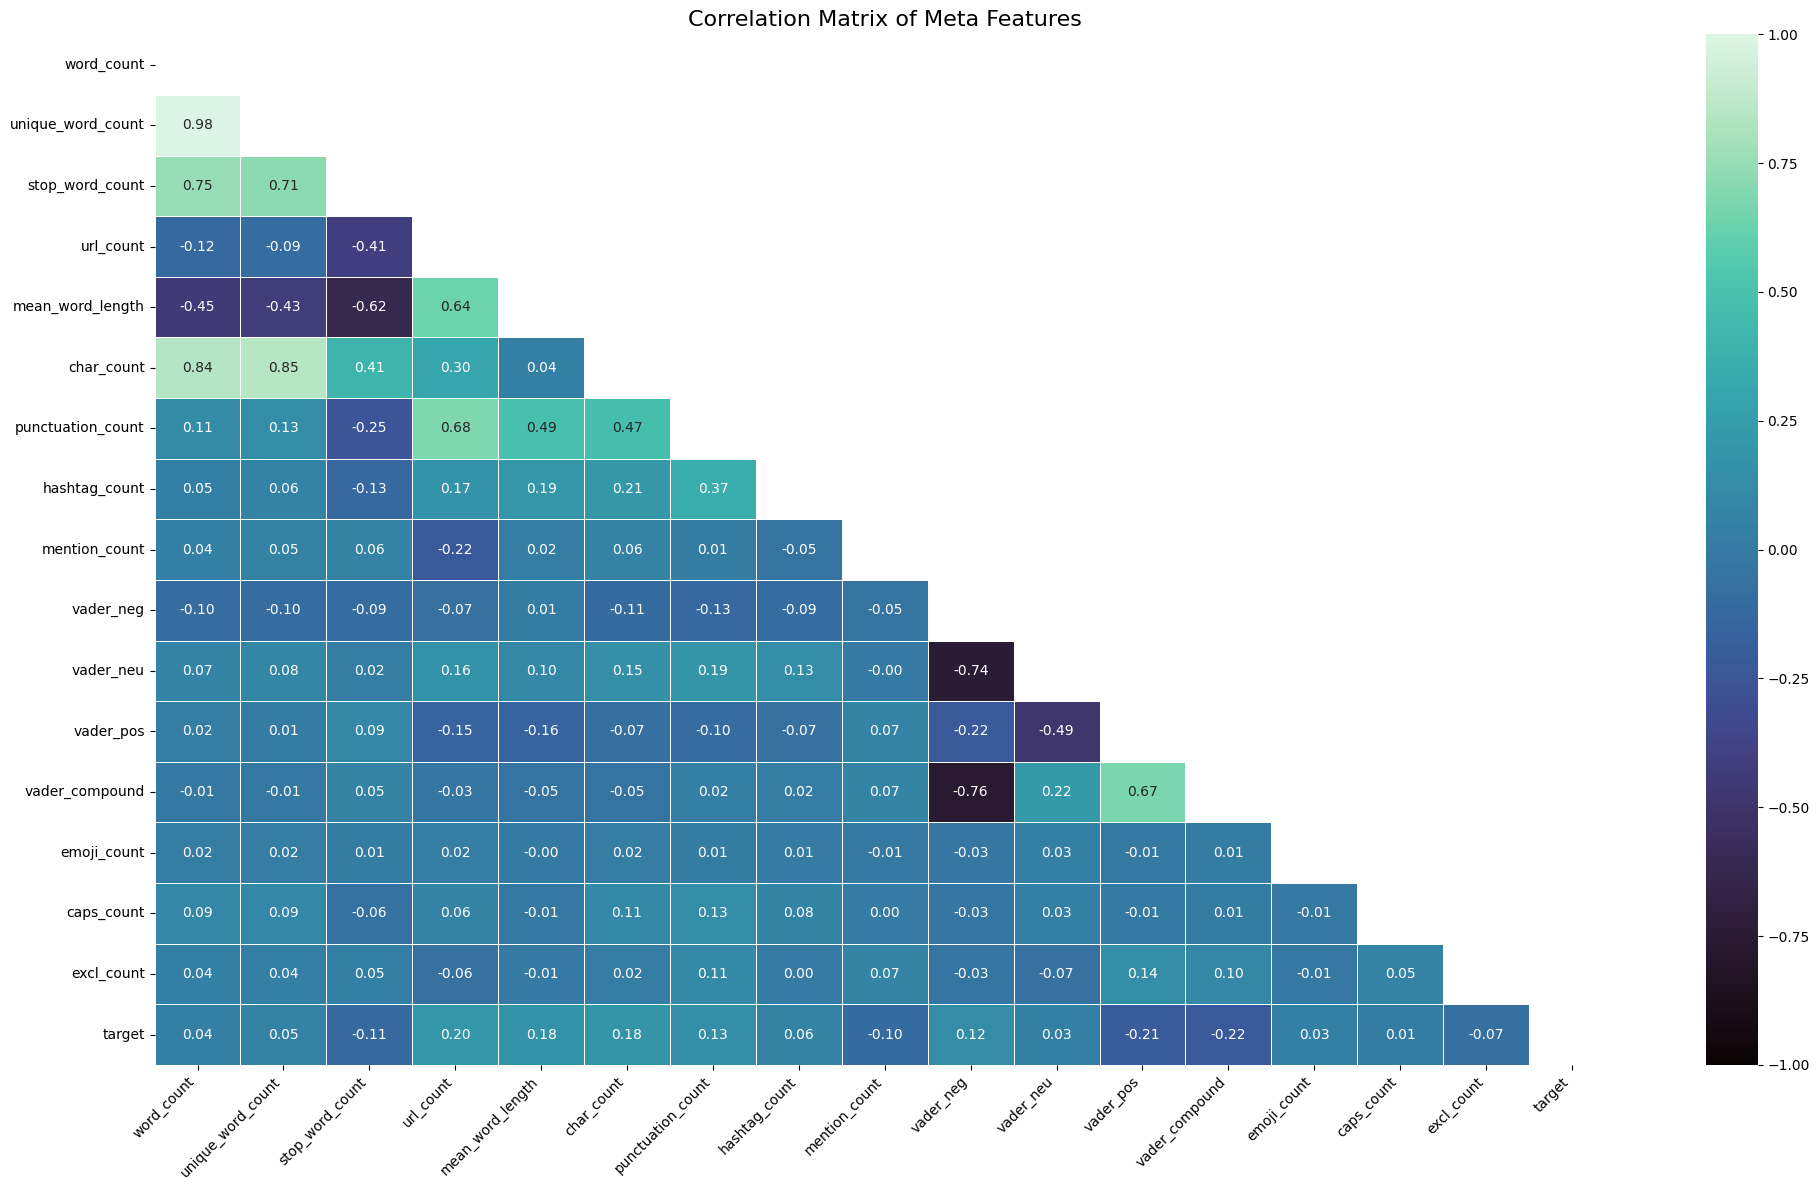

In [21]:
corr = df_train[METAFEATURES + ['target']].corr(numeric_only=True)


mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 12))

sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='mako', 
            fmt='.2f',
            vmin=-1, vmax=1,
            center=0,
            linewidths=.5)

plt.title('Correlation Matrix of Meta Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

***This type of correlation (Pearson coefficient) with binary target is unreliable!***

In [22]:
high_corr = corr.abs().stack().reset_index()
high_corr = high_corr[high_corr[0] > 0.9]
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
print("Highly correlated features:")
print(high_corr)

Highly correlated features:
              level_0            level_1         0
1          word_count  unique_word_count  0.984444
17  unique_word_count         word_count  0.984444


***Drop unique_word_count?***

In [23]:
from scipy.stats import ttest_ind

for feature in METAFEATURES:
    group1 = df_train[df_train['target'] == 1][feature]
    group0 = df_train[df_train['target'] == 0][feature]
    t_stat, p_value = ttest_ind(group1, group0)
    print(f"{feature}: p-value = {p_value:.4f} {'***' if p_value < 0.001 else ''}")

word_count: p-value = 0.0005 ***
unique_word_count: p-value = 0.0000 ***
stop_word_count: p-value = 0.0000 ***
url_count: p-value = 0.0000 ***
mean_word_length: p-value = 0.0000 ***
char_count: p-value = 0.0000 ***
punctuation_count: p-value = 0.0000 ***
hashtag_count: p-value = 0.0000 ***
mention_count: p-value = 0.0000 ***
vader_neg: p-value = 0.0000 ***
vader_neu: p-value = 0.0058 
vader_pos: p-value = 0.0000 ***
vader_compound: p-value = 0.0000 ***
emoji_count: p-value = 0.0026 
caps_count: p-value = 0.2956 
excl_count: p-value = 0.0000 ***


***Drop vader_neu, emoji_count, caps_count?***

In [24]:
from scipy.stats import pointbiserialr

print('Point-Biserial Correlation')
for feature in METAFEATURES:
    corr, p_value = pointbiserialr(df_train[feature], df_train['target'])
    print(f"{feature:20s}: corr = {corr:7.3f}, p-value = {p_value:.3g}")

Point-Biserial Correlation
word_count          : corr =   0.040, p-value = 0.000454
unique_word_count   : corr =   0.053, p-value = 3.65e-06
stop_word_count     : corr =  -0.110, p-value = 1.31e-21
url_count           : corr =   0.198, p-value = 6.24e-68
mean_word_length    : corr =   0.176, p-value = 6.3e-54
char_count          : corr =   0.181, p-value = 7.29e-57
punctuation_count   : corr =   0.133, p-value = 4.08e-31
hashtag_count       : corr =   0.059, p-value = 2.54e-07
mention_count       : corr =  -0.102, p-value = 6.73e-19
vader_neg           : corr =   0.124, p-value = 3.96e-27
vader_neu           : corr =   0.032, p-value = 0.0058
vader_pos           : corr =  -0.207, p-value = 5.14e-74
vader_compound      : corr =  -0.221, p-value = 3.45e-84
emoji_count         : corr =   0.035, p-value = 0.00256
caps_count          : corr =   0.012, p-value = 0.296
excl_count          : corr =  -0.073, p-value = 1.69e-10


***This type of correlation is preferable for binary target***

## Overall

In [25]:
from sklearn.metrics import roc_auc_score

results = []
for feature in METAFEATURES:
    # Point-Biserial
    corr, pval_pb = pointbiserialr(df_train[feature], df_train['target'])
    # ROC-AUC
    auc = roc_auc_score(df_train['target'], df_train[feature])
    # T-test
    group1 = df_train[df_train['target'] == 1][feature]
    group0 = df_train[df_train['target'] == 0][feature]
    t_stat, pval_tt = ttest_ind(group1, group0)
    
    results.append({
        'feature': feature,
        'Point-Biserial': f"{corr:.3f} (p={pval_pb:.3g})",
        'ROC-AUC': f"{auc:.3f}",
        'T-test': f"t={t_stat:.3f} (p={pval_tt:.3g})"
    })

pd.DataFrame(results).set_index('feature')

,Point-Biserial,ROC-AUC,T-test
feature,,,
word_count,0.040 (p=0.000454),0.525,t=3.508 (p=0.000454)
unique_word_count,0.053 (p=3.65e-06),0.529,t=4.634 (p=3.65e-06)
stop_word_count,-0.110 (p=1.31e-21),0.446,t=-9.578 (p=1.31e-21)
url_count,0.198 (p=6.24e-68),0.618,t=17.593 (p=6.24e-68)
mean_word_length,0.176 (p=6.3e-54),0.630,t=15.585 (p=6.3e-54)
char_count,0.181 (p=7.29e-57),0.595,t=16.025 (p=7.29e-57)
punctuation_count,0.133 (p=4.08e-31),0.594,t=11.653 (p=4.08e-31)
hashtag_count,0.059 (p=2.54e-07),0.532,t=5.160 (p=2.54e-07)
mention_count,-0.102 (p=6.73e-19),0.447,t=-8.903 (p=6.73e-19)


### Instructions (look at the last section)


**'#' – not good, but keep for now**

**'##' – better drop?**

**'###' / '####' – drop!**


### **Analysis**

#### **p-value**
**High p-value (>0.001):**
- word_count
- unique_word_count
- stop_word_count
- url_count
- mean_word_length
- char_count
- punctuation_count
- hashtag_count
- mention_count
- vader_neg
- vader_neu (p=0.0058) #
- vader_pos
- vader_compound
- emoji_count (p=0.00256) #
- caps_count (p=0.296) #
- excl_count

##### **ROC AUC**
**Bad ROC AUC ([0.45, 0.55])**
- word_count (auc=0.525) #
- unique_word_count (auc=0.529) #
- stop_word_count
- url_count
- mean_word_length
- char_count
- punctuation_count
- hashtag_count (auc=0.532) #
- mention_count
- vader_neg
- vader_neu (auc=0.514) ##
- vader_pos
- vader_compound
- emoji_count (auc=0.501) ##
- caps_count (auc=0.536) ##
- excl_count (auc=0.470) #

#### **PBC**
**Low correlation ([-0.100, 0.100])**
- word_count (pbc=0.040) ##
- unique_word_count (pbc=0.053) ##
- stop_word_count
- url_count
- mean_word_length
- char_count
- punctuation_count
- hashtag_count (pbc=0.059) ##
- mention_count
- vader_neg
- vader_neu (pbc=0.032) ###
- vader_pos
- vader_compound
- emoji_count (pbc=0.035) ###
- caps_count (pbc=0.012) ###
- excl_count (pbc=-0.073) ##

#### **T-test**
**Low t-value ([-5.00, 5.00])**
- word_count (t=3.508) ###
- unique_word_count ###
- stop_word_count
- url_count
- mean_word_length
- char_count
- punctuation_count
- hashtag_count ##
- mention_count
- vader_neg
- vader_neu (t=2.760) ####
- vader_pos
- vader_compound
- emoji_count (t=3.017) ####
- caps_count ####
- excl_count ##

### Overall
- word_count ### (DROP)
- unique_word_count ### (DROP)
- stop_word_count
- url_count
- mean_word_length
- char_count
- punctuation_count
- hashtag_count ## (MAYBE DROP)
- mention_count
- vader_neg
- vader_neu #### (DROP)
- vader_pos
- vader_compound
- emoji_count #### (DROP)
- caps_count #### (DROP)
- excl_count ## (MAYBE DROP)


### Keep features:

- stop_word_count
- url_count
- mean_word_length
- char_count
- punctuation_count
- hashtag_count (???)
- mention_count
- vader_neg
- vader_pos
- vader_compound
- excl_count (???)


### VIF for remaining featrures

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

features_for_vif = [
    'stop_word_count', 'url_count', 'mean_word_length', 
    'char_count', 'punctuation_count', 'hashtag_count',
    'mention_count', 'vader_neg', 'vader_pos',
    'vader_compound', 'excl_count'
]

X = df_train[features_for_vif]
X_with_const = pd.DataFrame({'const': 1}, index=X.index).join(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]

vif_data = vif_data[vif_data['feature'] != 'const'].sort_values("VIF", ascending=False)
print(vif_data)

              feature       VIF
10     vader_compound  6.762581
8           vader_neg  3.988497
2           url_count  3.154199
9           vader_pos  2.964964
5   punctuation_count  2.773381
1     stop_word_count  2.684158
3    mean_word_length  2.487291
4          char_count  2.344639
6       hashtag_count  1.228766
7       mention_count  1.202776
11         excl_count  1.078468


***Drop vader_compound?*** 

### VIF without vader_compound

In [27]:
features_for_vif = [
    'stop_word_count', 'url_count', 'mean_word_length', 
    'char_count', 'punctuation_count', 'hashtag_count',
    'mention_count', 'vader_neg', 'vader_pos', 'excl_count'
]

X = df_train[features_for_vif]
X_with_const = pd.DataFrame({'const': 1}, index=X.index).join(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]

vif_data = vif_data[vif_data['feature'] != 'const'].sort_values("VIF", ascending=False)
print(vif_data)

              feature       VIF
2           url_count  3.154196
5   punctuation_count  2.770856
1     stop_word_count  2.678785
3    mean_word_length  2.468324
4          char_count  2.272374
6       hashtag_count  1.228677
7       mention_count  1.202674
9           vader_pos  1.116694
8           vader_neg  1.103656
10         excl_count  1.078459


In [28]:
FEATURES = [
    'stop_word_count', 'url_count', 'mean_word_length', 
    'char_count', 'punctuation_count', 'hashtag_count',
    'mention_count', 'vader_neg', 'vader_pos', 'excl_count'
]

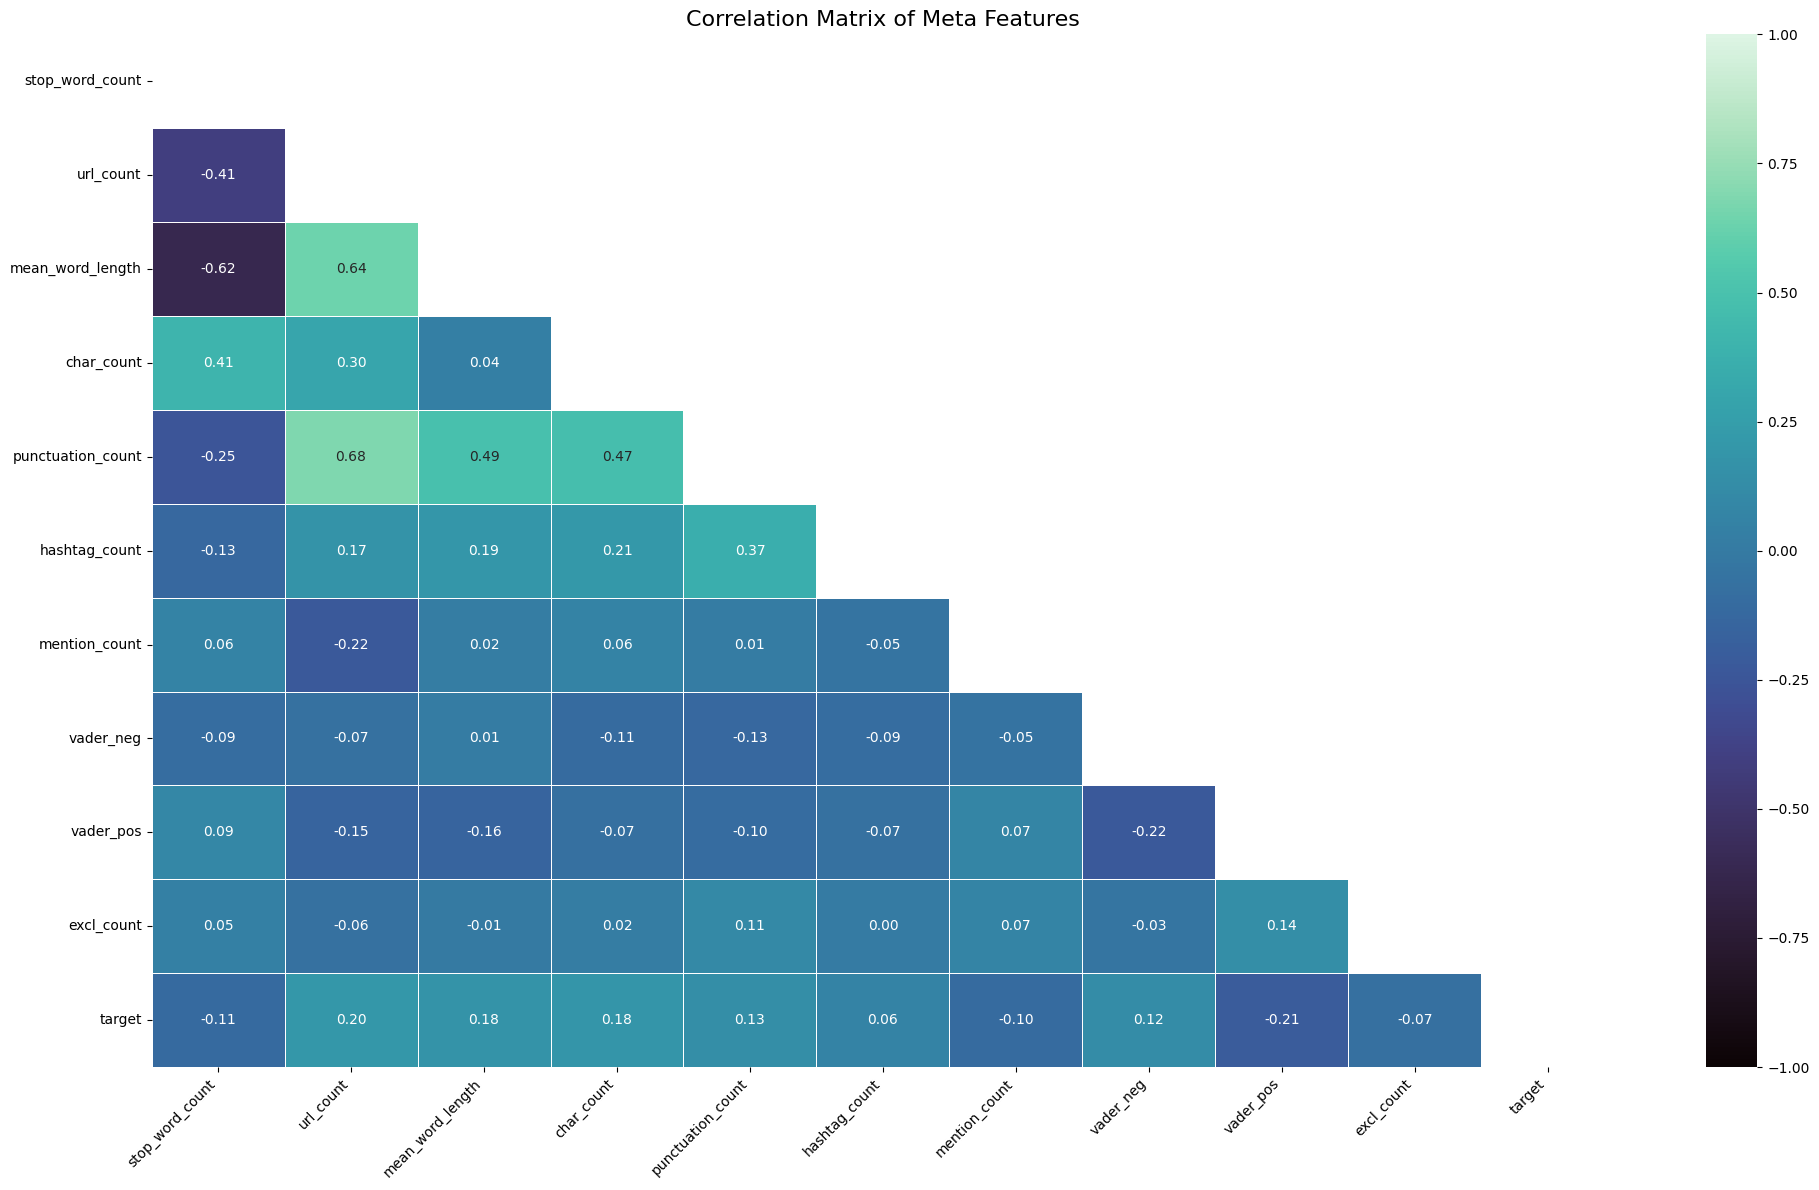

In [29]:
corr = df_train[FEATURES + ['target']].corr(numeric_only=True)


mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 12))

sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='mako', 
            fmt='.2f',
            vmin=-1, vmax=1,
            center=0,
            linewidths=.5)

plt.title('Correlation Matrix of Meta Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [30]:
METAFEATURES = [
    'word_count', 'unique_word_count', 'stop_word_count', 'url_count', 
    'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count',
    'mention_count', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
    'emoji_count', 'caps_count', 'excl_count'
]

FEATURES = [
    'stop_word_count', 'url_count', 'mean_word_length', 
    'char_count', 'punctuation_count', 'hashtag_count',
    'mention_count', 'vader_neg', 'vader_pos', 'excl_count'
]

to_drop = list(set(METAFEATURES) - set(FEATURES))

for df in [df_train, df_test]:
    cols_to_drop = [col for col in to_drop if col in df.columns]
    df.drop(columns=cols_to_drop, inplace=True)

print("df_train columns:", df_train.columns.tolist())
print("df_test columns:", df_test.columns.tolist())

df_train columns: ['keyword', 'location', 'text', 'target', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count', 'vader_neg', 'vader_pos', 'excl_count']
df_test columns: ['keyword', 'location', 'text', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count', 'vader_neg', 'vader_pos', 'excl_count']
